# Notes

**Important**

This notebook was created on *April 23, 2024, at 19:08*  with the intention of providing detailed explanations and interpretations of the processes involved. While Python scripts are powerful, they can sometimes be complex and require a significant investment in terms of analysis and understanding. This document aims to simplify this task by breaking down and explaining each code segment in detail.

In this notebook, we will undertake to revisit and detail the implementations of the MNIST dataset, a dataset widely used in the machine learning community, initially popularized by Yann LeCun. The goal is to implement two types of neural architectures: a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN). We will then compare their performances through various metrics.

Additionally, special attention will be given to visualizing backpropagation to identify the global optimum. This approach aims to illustrate not only how modifications to the weights affect model accuracy during training but also to demonstrate optimization dynamics in action.

This work is essential for those looking to deepen their understanding of deep learning fundamentals as well as for those wishing to refine their ability to optimize machine learning algorithms.

## Setup

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## PyTorch
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [22]:
# Load data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
print('Data are ready!')

Data are ready!


We have downloaded the data, now to extract the images and labels we will type the following command:

```bash
X = train_data.data
y = train_data.targets
```

In [23]:
# Examples
# Images are in uint8
print(f'The label ==> {trainset.targets[0]}')
trainset.data[0]

The label ==> 5


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Preparation

We are going to prepare the images here. The images are already in an appropriate format and require no special preparation other than normalization. As you may notice, the pixel values range from 0 to 255. This range can increase the computational load and introduce significant variance. Therefore, it is crucial to normalize the data. Using a MinMaxScaler normalization could be beneficial to scale our data from 0 to 1.

The MinMax normalization formula is given by: $MinMax = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$.

Next, we will load these normalized data into a DataLoader, which will compact our data and organize it into batches. This will enable us to use the GPU for computations, making the process more efficient.

In [25]:
# Store the data
# Print dimension of the data
print(f'train_set ==> {trainset.data.shape}')
print(f'test_set ==> {testset.data.shape}')

train_set ==> torch.Size([60000, 28, 28])
test_set ==> torch.Size([10000, 28, 28])


In [26]:
def plot_images_grid_from_dataset(dataset, num_images=25, title=None):
    """
    Plots a grid of images with labels directly from the dataset.

    Args:
    dataset (torch.utils.data.Dataset): Dataset from which to load the data.
    num_images (int): Number of images to display in the grid.
    title (str): Title of the plot.
    """
    if len(dataset) < num_images:
        raise ValueError("The dataset contains fewer images than the number requested for display.")
    
    # Manually fetch a batch of images and labels
    images = []
    labels = []
    for i in range(num_images):
        image, label = dataset[i]
        images.append(image)
        labels.append(label)
    
    # Convert lists to tensor
    images = torch.stack(images)
    labels = torch.tensor(labels)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(images, normalize=True, scale_each=True)

    # Show images
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)  # Rearrange the order of channels
    plt.axis('off')
    
    # Adding the title
    if title:
        plt.title(title)

    # Show labels in the title or a legend (optional)
    labels_str = ', '.join(map(str, labels.tolist()))
    plt.xlabel(f"Labels: {labels_str}")

    plt.show()

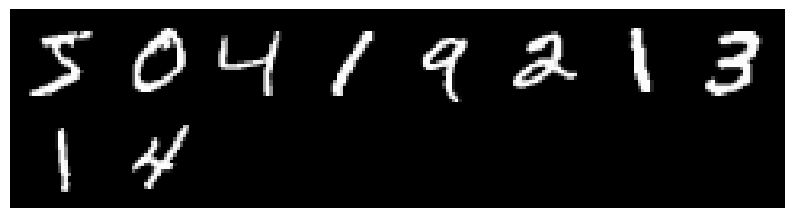

In [27]:
plot_images_grid_from_dataset(trainset, num_images=10)

These results indicate that our dataset contains 60,000 images, each with a height and width of 28 pixels. The structure of these data in a three-dimensional tensor (observations, height, width) also reveals that the images are in black and white, using a single channel. For color images, the tensor structure would include a fourth dimension corresponding to the color channels.

Let's move on to normalization:
The pixel values range from 0 to 255. Since the minimum value 
𝑋_min
X_min is zero, we can simplify the normalization by merely dividing each pixel by 255. This operation scales the pixel values to the range [0, 1], which is often required to optimize the performance of machine learning algorithms.

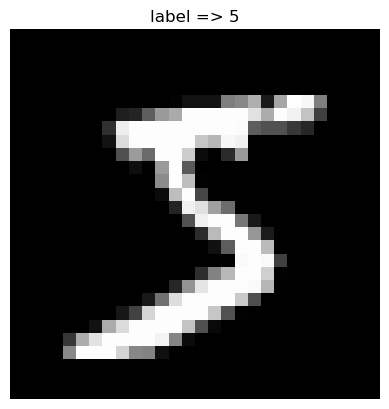

In [29]:
plt.title(f'label => {trainset.targets[0].numpy()}')
plt.axis('off')
plt.imshow(trainset.data[0], cmap='gray')

## Modeling

In [30]:
# Choose the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In this section, we will explore the design and implementation of neural network models, which are essentially assemblies of functions $f(x)$ working together to solve complex problems through the aggregation of their predictions. The origins of neural networks date back to the 1960s with the introduction of the perceptron by Frank Rosenblatt. This model is described by the equation $y = W \cdot X + b$, where $W$ represents the weights, $X$ the inputs, and $b$ the bias. However, despite this innovation, the perceptron was limited to solving linear problems due to its fundamental structure.

The advent of the 1980s and 1990s saw significant advancements in this field thanks to the work of Geoffrey Hinton and others, who developed the MultiLayer Perceptron (MLP). The MLP is a network composed of multiple layers of perceptrons, enabling it to capture complex nonlinearities and handle problems well beyond the capabilities of the simple perceptron. This enhanced ability makes the MLP particularly effective for a variety of applications ranging from image recognition to predictive modeling in financial and medical domains.

We will now proceed to the practical implementation of an MLP. This model, structured in successive layers of neurons with nonlinear activations, allows for modeling complex relationships between inputs and desired outputs. Achieving this objective involves a deep understanding of the underlying principles of tensor calculus, gradients, and backpropagation—crucial elements for the effective training of neural networks.

This exploration is set within a context of ongoing research where neural network models are constantly refined to improve their accuracy, efficiency, and applicability to an increasingly broad array of complex challenges across various scientific and engineering fields. Thus, the development of MLPs is not just a technical task but also a quest to extend the boundaries of what machines can learn to do from data.

In [31]:
def Trainer(dataloader, validloader, model, criterion, optimizer, epochs=10):
    """
    Improved training function using provided dataloaders, model, criterion, optimizer for specified epochs.
    """
    model = model.to(device)  # Ensure model is on the right device
    loss_cache = []
    valid_cache = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        start_time = time.time()
        for X, y in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_cache.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{epochs}] - Avg Training Loss: {avg_loss:.6f}")

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total_correct = 0
        total_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in validloader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds_val = model(X_val)
                val_loss = criterion(preds_val, y_val)
                total_val_loss += val_loss.item()
                total_correct += (preds_val.argmax(1) == y_val).type(torch.float).sum().item()

        avg_val_loss = total_val_loss / len(validloader)
        accuracy = total_correct / len(validloader.dataset)
        valid_cache.append({'avg_val_loss': avg_val_loss, 'accuracy': accuracy})
        print(f"Validation - Avg Loss: {avg_val_loss:.6f} | Accuracy: {accuracy * 100:.2f}%")

        # Timing
        elapsed_time = time.time() - start_time
        print(f"Time for epoch {epoch + 1}: {elapsed_time:.2f}s")

    return loss_cache, valid_cache



def predict_mnist(model, img, label):
  """
  Prediction 
  """
  model.eval()
  img_tensor = torch.tensor(img, dtype = torch.float32)
  img_tensor = img_tensor.unsqueeze(0)
  with torch.no_grad():
    img_tensor = img_tensor.to(device)
    preds = model(img_tensor)
    probabilities = torch.softmax(preds, dim=1)
    top_probabilities, top_labels = torch.topk(probabilities, 2)

  top_probabilities = top_probabilities[0].cpu().numpy()
  top_labels = top_labels[0].cpu().numpy()

  color_title = 'green' if label == top_labels[0] else 'red'

  title_text = (f'Predicted: {top_labels[0]} => Probability: {top_probabilities[0] * 100:.2f}%, \n'
              f'Second Predicted: {top_labels[1]} => Probability: {top_probabilities[1] * 100:.2f}%')


  plt.title(title_text, color=color_title)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()


<img src="img/Perceptron.drawio.png" alt="perceptron" width="50%" height="50%">


In [32]:
# Perform a Perceptron
class Perceptron(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Perceptron, self).__init__()
        # Ensure the input dimension is correctly provided
        self.y = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # Here is to Flatten the Data, we will explain after
        x = self.y(x)
        return x

The `x.view` method is crucial for preparing input data for neural networks, particularly when images are processed by perceptrons that only understand data in vector form. This function resizes tensors without altering the underlying data, allowing the transformation of an image, typically represented by a matrix or 3D tensor, into a one-dimensional vector.

Applying `x.view(self.input_size.size(0), 1)` reshapes the tensor to fit the network's input dimensions, converting all image features into a single linear vector. This vectorization is essential because it enables the perceptron to process each image pixel as part of a linear sequence of numerical values, thus facilitating classification based on global features rather than the spatial structure of the image.

In [33]:
# Assuming input dimensions for MNIST (28x28 images)
input_dim = 28 * 28
num_classes = 10
#parameters
lr = 1e-3

# Define hyperparameters
criterion = nn.CrossEntropyLoss()

In [34]:
perceptron = Perceptron(input_dim, num_classes)
print(perceptron)

Perceptron(
  (y): Linear(in_features=784, out_features=10, bias=True)
)


In [38]:
optimizer = optim.Adam(perceptron.parameters(), lr = lr)

In [39]:
loss_cache, valid_cache = Trainer(trainloader, testloader, perceptron, criterion, optimizer)

Epoch 1/10: 100%|██████████| 938/938 [00:05<00:00, 178.27batch/s]

Epoch [1/10] - Avg Training Loss: 6.043198


Validation - Avg Loss: 0.815851 | Accuracy: 81.77%
Time for epoch 1: 6.22s


Epoch 2/10: 100%|██████████| 938/938 [00:05<00:00, 177.84batch/s]

Epoch [2/10] - Avg Training Loss: 0.670265


Validation - Avg Loss: 0.522723 | Accuracy: 86.73%
Time for epoch 2: 6.23s


Epoch 3/10: 100%|██████████| 938/938 [00:05<00:00, 185.96batch/s]

Epoch [3/10] - Avg Training Loss: 0.499845


Validation - Avg Loss: 0.425754 | Accuracy: 88.99%
Time for epoch 3: 5.98s


Epoch 4/10: 100%|██████████| 938/938 [00:05<00:00, 186.41batch/s]

Epoch [4/10] - Avg Training Loss: 0.421659


Validation - Avg Loss: 0.377847 | Accuracy: 89.92%
Time for epoch 4: 5.99s


Epoch 5/10: 100%|██████████| 938/938 [00:05<00:00, 186.62batch/s]

Epoch [5/10] - Avg Training Loss: 0.381744


Validation - Avg Loss: 0.353240 | Accuracy: 90.35%
Time for epoch 5: 6.01s


Epoch 6/10: 100%|██████████| 938/938 [00:05<00:00, 176.41batch/s]

Epoch [6/10] - Avg Training Loss: 0.352369


Validation - Avg Loss: 0.333116 | Accuracy: 91.08%
Time for epoch 6: 6.32s


Epoch 7/10: 100%|██████████| 938/938 [00:06<00:00, 144.84batch/s]

Epoch [7/10] - Avg Training Loss: 0.335356


Validation - Avg Loss: 0.340800 | Accuracy: 90.74%
Time for epoch 7: 7.77s


Epoch 8/10: 100%|██████████| 938/938 [00:07<00:00, 128.69batch/s]

Epoch [8/10] - Avg Training Loss: 0.321842


Validation - Avg Loss: 0.308293 | Accuracy: 91.78%
Time for epoch 8: 8.55s


Epoch 9/10: 100%|██████████| 938/938 [00:07<00:00, 120.32batch/s]

Epoch [9/10] - Avg Training Loss: 0.313788


Validation - Avg Loss: 0.301300 | Accuracy: 92.08%
Time for epoch 9: 9.08s


Epoch 10/10: 100%|██████████| 938/938 [00:07<00:00, 125.58batch/s]

Epoch [10/10] - Avg Training Loss: 0.305948


Validation - Avg Loss: 0.302741 | Accuracy: 91.94%
Time for epoch 10: 8.67s


/tmp/ipykernel_165697/2161672485.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype = torch.float32)


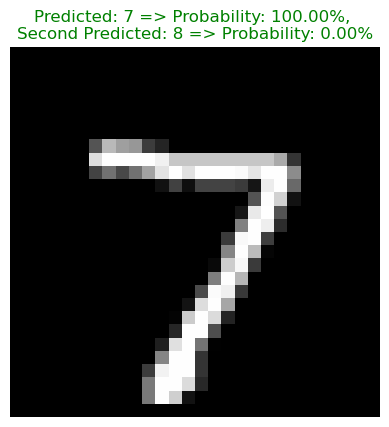

In [62]:
predict_mnist(perceptron, testset.data[0], testset.targets[0])

It is crucial to understand the limitations of machine learning models, particularly in the context of the simple perceptron, which is often used for linearly separable problems. The perceptron, being a linear classifier, finds its limits in environments where the data are not linearly separable.

### Analysis of the Perceptron's Limitations

The simple perceptron makes its predictions based on a linear decision function of the form $f(x) = w \cdot x + b$, where $(w)$ represents the weights, $(x)$ the inputs, and $(b)$ the bias. In cases where the data cannot be separated by a single straight line (or hyperplane in higher-dimensional spaces), the perceptron fails to converge to a solution.

For example, consider an image with dimensions width × height × channels. This structure of multivariable and high-dimensionality data exceeds the capabilities of the simple perceptron. In reality, each pixel in the image could influence the classification label in a nonlinear manner, which is beyond the reach for a model that can only use a linear decision boundary.

In [42]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

In [43]:
multilayer = MLP(input_dim) # MLP is also called DNN for Dense Neural Network or ANN Artificail Neural Network
print(multilayer)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [44]:
optimizer_mlp = optim.Adam(multilayer.parameters(), lr = lr)
loss_cache_mlp, valid_cache_mlp = Trainer(trainloader, testloader, multilayer, criterion, optimizer_mlp)

Epoch 1/10: 100%|██████████| 938/938 [00:05<00:00, 181.46batch/s]

Epoch [1/10] - Avg Training Loss: 0.317665


Validation - Avg Loss: 0.151819 | Accuracy: 95.21%
Time for epoch 1: 6.09s


Epoch 2/10: 100%|██████████| 938/938 [00:05<00:00, 174.80batch/s]

Epoch [2/10] - Avg Training Loss: 0.143407


Validation - Avg Loss: 0.115623 | Accuracy: 96.17%
Time for epoch 2: 6.30s


Epoch 3/10: 100%|██████████| 938/938 [00:05<00:00, 169.41batch/s]

Epoch [3/10] - Avg Training Loss: 0.105312


Validation - Avg Loss: 0.105173 | Accuracy: 96.70%
Time for epoch 3: 6.48s


Epoch 4/10: 100%|██████████| 938/938 [00:05<00:00, 170.15batch/s]

Epoch [4/10] - Avg Training Loss: 0.084616


Validation - Avg Loss: 0.099301 | Accuracy: 96.85%
Time for epoch 4: 6.47s


Epoch 5/10: 100%|██████████| 938/938 [00:05<00:00, 166.59batch/s]

Epoch [5/10] - Avg Training Loss: 0.072410


Validation - Avg Loss: 0.099316 | Accuracy: 96.98%
Time for epoch 5: 6.58s


Epoch 6/10: 100%|██████████| 938/938 [00:06<00:00, 135.80batch/s]

Epoch [6/10] - Avg Training Loss: 0.063757


Validation - Avg Loss: 0.090679 | Accuracy: 97.22%
Time for epoch 6: 8.09s


Epoch 7/10: 100%|██████████| 938/938 [00:08<00:00, 114.64batch/s]

Epoch [7/10] - Avg Training Loss: 0.055343


Validation - Avg Loss: 0.092036 | Accuracy: 96.95%
Time for epoch 7: 9.49s


Epoch 8/10: 100%|██████████| 938/938 [00:08<00:00, 116.11batch/s]

Epoch [8/10] - Avg Training Loss: 0.048622


Validation - Avg Loss: 0.085663 | Accuracy: 97.45%
Time for epoch 8: 9.36s


Epoch 9/10: 100%|██████████| 938/938 [00:07<00:00, 117.48batch/s]

Epoch [9/10] - Avg Training Loss: 0.045229


Validation - Avg Loss: 0.091272 | Accuracy: 97.36%
Time for epoch 9: 9.22s


Epoch 10/10: 100%|██████████| 938/938 [00:07<00:00, 131.59batch/s]

Epoch [10/10] - Avg Training Loss: 0.039449


Validation - Avg Loss: 0.081227 | Accuracy: 97.62%
Time for epoch 10: 8.22s


/tmp/ipykernel_165697/2161672485.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype = torch.float32)


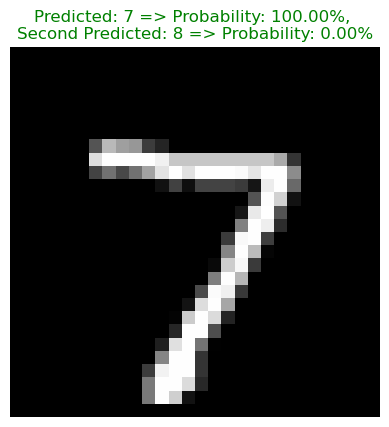

In [46]:
predict_mnist(multilayer, testset.data[0], testset.targets[0])

We have observed improvements with the Multi-Layer Perceptron (MLP) model, but the results remain unsatisfactory. As previously mentioned, the MLP does not inherently process images as such; it requires the transformation of images into one-dimensional vectors. This vectorization process has a significant drawback: it destroys the spatial information contained in the image, specifically the relative arrangement of pixels.

To overcome this limitation, Convolutional Neural Networks (CNNs) have been developed. These models are specifically designed to handle images as inputs, preserving and leveraging spatial information through the application of convolutional filters. CNNs are able to extract the most relevant features from images, significantly enhancing their ability to make accurate predictions.

One of the earliest CNN architectures implemented was LeNet, developed by Yann LeCun in 1986. This network was revolutionary in the field of deep learning as it introduced the concept of convolutions that effectively capture essential details and structures in images. LeNet laid the groundwork for modern CNN architectures, which are now central to many computer vision applications.

We will explore the workings and foundational principles of LeNet to understand how it captures meaningful spatial information and thus improves the quality of predictions on visual data.

In [58]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4x4 is the dimension after pooling and convolution operations
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 16*4*4)  # Flatten the tensor correctly
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [59]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [60]:
optimizer_net = optim.Adam(net.parameters(), lr = lr)
loss_cache_net, valid_cache_net = Trainer(trainloader, testloader, net, criterion, optimizer_net)

Epoch 1/10: 100%|██████████| 938/938 [00:05<00:00, 179.12batch/s]

Epoch [1/10] - Avg Training Loss: 0.243812


Validation - Avg Loss: 0.060828 | Accuracy: 98.12%
Time for epoch 1: 6.21s


Epoch 2/10: 100%|██████████| 938/938 [00:05<00:00, 178.18batch/s]

Epoch [2/10] - Avg Training Loss: 0.069895


Validation - Avg Loss: 0.048163 | Accuracy: 98.53%
Time for epoch 2: 6.21s


Epoch 3/10: 100%|██████████| 938/938 [00:05<00:00, 175.32batch/s]

Epoch [3/10] - Avg Training Loss: 0.050365


Validation - Avg Loss: 0.041293 | Accuracy: 98.57%
Time for epoch 3: 6.30s


Epoch 4/10: 100%|██████████| 938/938 [00:05<00:00, 165.27batch/s]

Epoch [4/10] - Avg Training Loss: 0.040736


Validation - Avg Loss: 0.039313 | Accuracy: 98.73%
Time for epoch 4: 6.61s


Epoch 5/10: 100%|██████████| 938/938 [00:05<00:00, 167.08batch/s]

Epoch [5/10] - Avg Training Loss: 0.034680


Validation - Avg Loss: 0.041740 | Accuracy: 98.64%
Time for epoch 5: 6.56s


Epoch 6/10: 100%|██████████| 938/938 [00:05<00:00, 162.21batch/s]

Epoch [6/10] - Avg Training Loss: 0.027815


Validation - Avg Loss: 0.038179 | Accuracy: 98.76%
Time for epoch 6: 6.86s


Epoch 7/10: 100%|██████████| 938/938 [00:07<00:00, 132.92batch/s]

Epoch [7/10] - Avg Training Loss: 0.024132


Validation - Avg Loss: 0.038345 | Accuracy: 98.76%
Time for epoch 7: 8.61s


Epoch 8/10: 100%|██████████| 938/938 [00:09<00:00, 94.49batch/s] 

Epoch [8/10] - Avg Training Loss: 0.019950


Validation - Avg Loss: 0.036364 | Accuracy: 98.86%
Time for epoch 8: 11.42s


Epoch 9/10: 100%|██████████| 938/938 [00:09<00:00, 101.45batch/s]

Epoch [9/10] - Avg Training Loss: 0.018189


Validation - Avg Loss: 0.034968 | Accuracy: 98.97%
Time for epoch 9: 10.63s


Epoch 10/10: 100%|██████████| 938/938 [00:08<00:00, 114.00batch/s]

Epoch [10/10] - Avg Training Loss: 0.016140


Validation - Avg Loss: 0.033741 | Accuracy: 98.98%
Time for epoch 10: 9.52s


/tmp/ipykernel_165697/2161672485.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img, dtype = torch.float32)


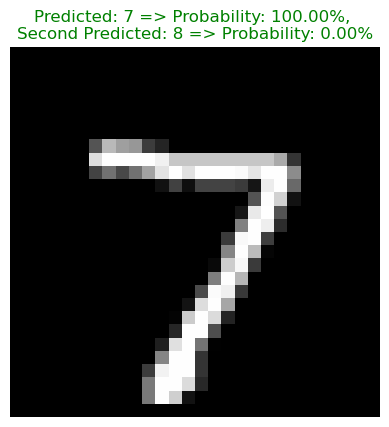

In [61]:
predict_mnist(net, testset.data[0], testset.targets[0])

In [ ]:
# To continue